Binder URL

In [33]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.style.use("seaborn")

In [34]:
def calculate_ema(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema

In [35]:

def calculate_macd(prices, fast, slow, smoothing=2):
    fast_ema=pd.DataFrame(calculate_ema(prices,fast),index=np.arange(fast,len(prices)+1),columns=['fast_ema'])
    slow_ema=pd.DataFrame(calculate_ema(prices,slow),index=np.arange(slow,len(prices)+1),columns=['slow_ema'])
    df_macd = pd.concat([fast_ema,slow_ema], axis=1, join="outer")[:-1]
    df_macd['macd']=df_macd['fast_ema']-df_macd['slow_ema']
    df_macd=df_macd[['macd']]
    return df_macd

In [36]:
# 1. Download Date from yfinance
ticker = 'BTC-USD'
start = dt.datetime.today()-dt.timedelta(3000)
end = dt.datetime.today()
ohlc_intraday = {}
ohlc_intraday[ticker] = yf.download(ticker,start,end)
ohlc_intraday[ticker] = ohlc_intraday[ticker].reset_index(drop = False)
df_signal = ohlc_intraday[ticker].copy()
df_signal

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
2750,2022-03-29,47100.437500,48022.289062,47100.437500,47465.730469,47465.730469,31397059069
2751,2022-03-30,47456.898438,47655.148438,46746.210938,47062.664062,47062.664062,29333883962
2752,2022-03-31,47062.148438,47512.027344,45390.539062,45538.675781,45538.675781,33327427106
2753,2022-04-01,45554.164062,46616.242188,44403.140625,46281.644531,46281.644531,38162644287


In [37]:
# 2.remove some columns
df_signal = df_signal[['Date','Close']]
df_signal

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
2750,2022-03-29,47465.730469
2751,2022-03-30,47062.664062
2752,2022-03-31,45538.675781
2753,2022-04-01,46281.644531


In [38]:
# 3.Add ema
fast = 20
slow = 40
macd=calculate_macd(df_signal["Close"],fast,slow)
df_signal = pd.concat([df_signal,macd],axis=1,join='outer')[:-1]
df_signal

,Date,Close,macd
0,2014-09-17,457.334015,NaN
1,2014-09-18,424.440002,NaN
2,2014-09-19,394.795990,NaN
3,2014-09-20,408.903992,NaN
4,2014-09-21,398.821014,NaN
...,...,...,...
2749,2022-03-28,47128.003906,693.101084
2750,2022-03-29,47465.730469,886.755109
2751,2022-03-30,47062.664062,1064.989342
2752,2022-03-31,45538.675781,1194.709380


In [39]:
divergence_condition = df_signal['macd'] > 0
df_signal['Divergence']=np.where(divergence_condition,df_signal['macd']-df_signal['macd'].shift(1), None)
# df_signal['Divergence']=np.where(df_signal['macd']-df_signal['macd'].shift(1))

In [40]:
# 4. Find days 'hold'
condition =  df_signal['macd'] > 0
df_signal['Hold']=np.where(condition, 'Hold', '')
df_signal

,Date,Close,macd,Divergence,Hold
0,2014-09-17,457.334015,NaN,None,
1,2014-09-18,424.440002,NaN,None,
2,2014-09-19,394.795990,NaN,None,
3,2014-09-20,408.903992,NaN,None,
4,2014-09-21,398.821014,NaN,None,
...,...,...,...,...,...
2749,2022-03-28,47128.003906,693.101084,212.156614,Hold
2750,2022-03-29,47465.730469,886.755109,193.654025,Hold
2751,2022-03-30,47062.664062,1064.989342,178.234233,Hold
2752,2022-03-31,45538.675781,1194.709380,129.720038,Hold


In [41]:
# 5. Find 'buy','sell' day

df_signal['Hold_t-1']=df_signal['Hold'].shift(1)
df_signal['Hold_t-2']=df_signal['Hold'].shift(2)

buy_condition = (df_signal['Hold_t-2'] =='') & (df_signal['Hold_t-1'] =='Hold')
df_signal['Buy']=np.where(buy_condition, 'Buy', '')

# sell_condition = (df_signal['Hold_t-2'] =='Hold') & (df_signal['Hold_t-1'] =='')
sell_condition = (df_signal['Hold_t-2'] =='Hold')
df_signal['Sell']=np.where(sell_condition, 'Sell', '')

df_signal

,Date,Close,macd,Divergence,Hold,Hold_t-1,Hold_t-2,Buy,Sell
0,2014-09-17,457.334015,NaN,None,,NaN,NaN,,
1,2014-09-18,424.440002,NaN,None,,,NaN,,
2,2014-09-19,394.795990,NaN,None,,,,,
3,2014-09-20,408.903992,NaN,None,,,,,
4,2014-09-21,398.821014,NaN,None,,,,,
...,...,...,...,...,...,...,...,...,...
2749,2022-03-28,47128.003906,693.101084,212.156614,Hold,Hold,Hold,,Sell
2750,2022-03-29,47465.730469,886.755109,193.654025,Hold,Hold,Hold,,Sell
2751,2022-03-30,47062.664062,1064.989342,178.234233,Hold,Hold,Hold,,Sell
2752,2022-03-31,45538.675781,1194.709380,129.720038,Hold,Hold,Hold,,Sell


In [42]:
sell_condition = (df_signal['Hold_t-2'] =='Hold') & (df_signal['Hold_t-1'] =='')

In [43]:
# ml
# 6. remove some columns
df_signal = df_signal[['Date','macd','Divergence','Buy','Sell']]
df_signal

,Date,macd,Divergence,Buy,Sell
0,2014-09-17,NaN,None,,
1,2014-09-18,NaN,None,,
2,2014-09-19,NaN,None,,
3,2014-09-20,NaN,None,,
4,2014-09-21,NaN,None,,
...,...,...,...,...,...
2749,2022-03-28,693.101084,212.156614,,Sell
2750,2022-03-29,886.755109,193.654025,,Sell
2751,2022-03-30,1064.989342,178.234233,,Sell
2752,2022-03-31,1194.709380,129.720038,,Sell


In [44]:
# 7. filter days sending order
condition = (df_signal['Buy']=='Buy') | (df_signal['Sell']=='Sell')

df_signal = df_signal[condition]
df_signal = df_signal.reset_index(drop = True)
df_signal

,Date,macd,Divergence,Buy,Sell
0,2014-11-18,1.547954,0.707592,Buy,
1,2014-11-19,1.582489,0.034534,,Sell
2,2014-11-20,1.853731,0.271243,,Sell
3,2014-11-21,1.023274,-0.830458,,Sell
4,2014-11-22,-0.021027,None,,Sell
...,...,...,...,...,...
1614,2022-03-28,693.101084,212.156614,,Sell
1615,2022-03-29,886.755109,193.654025,,Sell
1616,2022-03-30,1064.989342,178.234233,,Sell
1617,2022-03-31,1194.709380,129.720038,,Sell


In [45]:
# 8. Make trading dataframe
columns_Trading = ['Date_Buy','Price_Buy','Date_Sell','Price_Sell','macd','Divergence','PL(%)','Holding_Days']
df_Trading = pd.DataFrame(columns = columns_Trading)
df_Trading

,Date_Buy,Price_Buy,Date_Sell,Price_Sell,macd,Divergence,PL(%),Holding_Days


In [46]:
last_buy = 0
for i in range(0,len(df_signal),2):
    if(i<len(df_signal)-1):
        if (df_signal['Buy'][i]=='Buy'):
            last_buy = i
        else:
            Date_Buy = df_signal['Date'][last_buy]
            Date_Sell = df_signal['Date'][i]
            macd = df_signal['macd'][i]
            divergence = df_signal['Divergence'][i]
            Price_Buy = ohlc_intraday[ticker][ohlc_intraday[ticker]['Date']==Date_Buy][['Open']].values[0][0]
            Price_Sell = ohlc_intraday[ticker][ohlc_intraday[ticker]['Date']==Date_Sell][['Open']].values[0][0]
            fee = 0.002 * (Price_Buy + Price_Sell)
            Holding_Days = abs(Date_Sell-Date_Buy).days
            PL = (Price_Sell-Price_Buy-fee)*100/Price_Buy

            Add_Trading = pd.DataFrame([[Date_Buy,Price_Buy,Date_Sell,Price_Sell,macd,divergence,PL,Holding_Days]],columns = columns_Trading)
            df_Trading = df_Trading.append(Add_Trading)

df_Trading = df_Trading.reset_index(drop = True)
df_Trading = df_Trading.round(2)
df_Trading.dropna(inplace=True)
df_Trading

,Date_Buy,Price_Buy,Date_Sell,Price_Sell,macd,Divergence,PL(%),Holding_Days
0,2014-11-18,387.79,2014-11-20,380.31,1.85,0.27,-2.32,2
2,2014-11-30,375.51,2014-12-02,379.25,1.04,0.32,0.59,2
3,2014-11-30,375.51,2014-12-04,375.72,1.43,0.02,-0.34,4
4,2014-11-30,375.51,2014-12-06,376.76,1.31,0.12,-0.07,6
5,2014-11-30,375.51,2014-12-08,374.96,1.32,0.01,-0.54,8
...,...,...,...,...,...,...,...,...
791,2021-10-06,51486.66,2021-11-25,57165.42,521.56,-232.80,10.61,50
792,2021-10-06,51486.66,2021-11-27,53736.43,56.40,-308.58,3.96,52
794,2021-10-06,51486.66,2022-03-26,44349.86,357.05,137.67,-14.23,171
795,2021-10-06,51486.66,2022-03-28,46821.85,693.10,212.16,-9.44,173


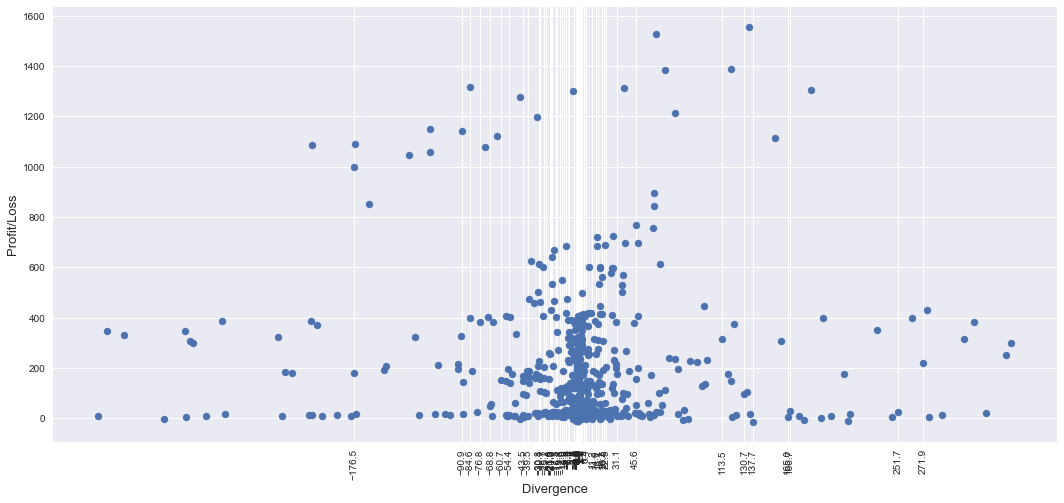

In [47]:
plt.figure(figsize= (18, 8))
x= df_Trading.Divergence
y= df_Trading['PL(%)']
plt.scatter(x, y, s= 50)
plt.xlabel("Divergence", fontsize = 13)
plt.ylabel("Profit/Loss", fontsize= 13)
plt.xticks(x[::10],  rotation='vertical')
plt.show()

In [48]:
from sklearn.linear_model import LinearRegression

In [49]:
lm = LinearRegression(fit_intercept = True)

In [50]:
lm.fit(X= df_Trading.Divergence.to_frame(), y= df_Trading['PL(%)'])


LinearRegression()

In [51]:
slope = lm.coef_
slope

array([-0.05612745])

In [52]:
intercept = lm.intercept_
intercept

172.04512410017324

In [53]:
df_Trading["pred"] = lm.predict(df_Trading.Divergence.to_frame())
df_Trading

,Date_Buy,Price_Buy,Date_Sell,Price_Sell,macd,Divergence,PL(%),Holding_Days,pred
0,2014-11-18,387.79,2014-11-20,380.31,1.85,0.27,-2.32,2,172.029970
2,2014-11-30,375.51,2014-12-02,379.25,1.04,0.32,0.59,2,172.027163
3,2014-11-30,375.51,2014-12-04,375.72,1.43,0.02,-0.34,4,172.044002
4,2014-11-30,375.51,2014-12-06,376.76,1.31,0.12,-0.07,6,172.038389
5,2014-11-30,375.51,2014-12-08,374.96,1.32,0.01,-0.54,8,172.044563
...,...,...,...,...,...,...,...,...,...
791,2021-10-06,51486.66,2021-11-25,57165.42,521.56,-232.80,10.61,50,185.111594
792,2021-10-06,51486.66,2021-11-27,53736.43,56.40,-308.58,3.96,52,189.364931
794,2021-10-06,51486.66,2022-03-26,44349.86,357.05,137.67,-14.23,171,164.318059
795,2021-10-06,51486.66,2022-03-28,46821.85,693.10,212.16,-9.44,173,160.137125


In [54]:
x_lin = np.array([-500, 500])
y_lin = intercept + slope * x_lin
y_lin

array([200.10884726, 143.98140094])

In [55]:
pm = np.polyfit(df_Trading.Divergence, df_Trading['PL(%)'], 4)

In [56]:
x_poly = np.linspace(-400, 400, 10000)

In [57]:
y_poly = np.polyval(pm, x_poly)

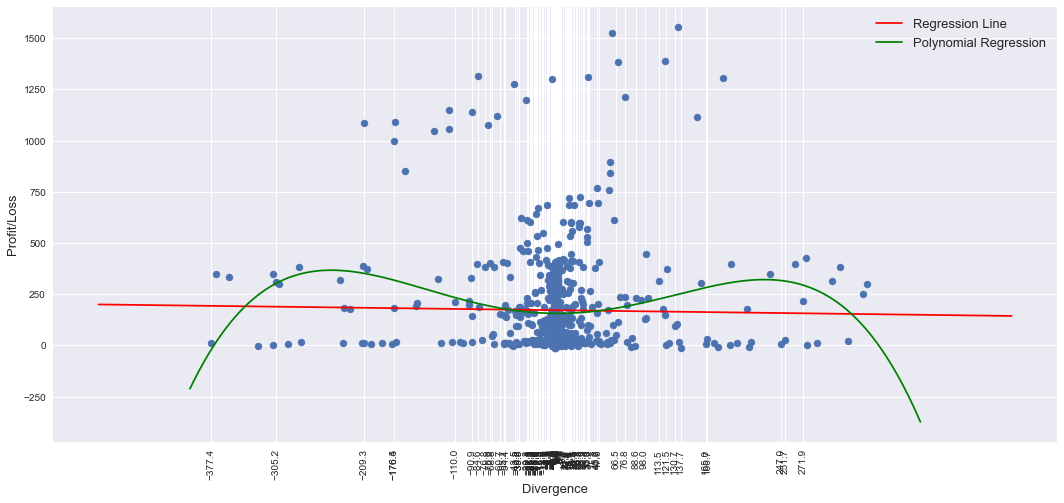

In [58]:
plt.figure(figsize= (18, 8))
x= df_Trading.Divergence
y= df_Trading['PL(%)']
plt.scatter(x, y, s= 50)
plt.plot(x_lin, y_lin, c= "red", label= "Regression Line")
plt.plot(x_poly, y_poly, label= "Polynomial Regression", color="green")
plt.xlabel("Divergence", fontsize = 13)
plt.ylabel("Profit/Loss", fontsize= 13)
plt.xticks(x[::5],  rotation='vertical')
plt.legend(fontsize= 13)
plt.show()

In [59]:
# 6. remove some columns
df_signal = df_signal[['Date','Buy','Sell']]
df_signal

,Date,Buy,Sell
0,2014-11-18,Buy,
1,2014-11-19,,Sell
2,2014-11-20,,Sell
3,2014-11-21,,Sell
4,2014-11-22,,Sell
...,...,...,...
1614,2022-03-28,,Sell
1615,2022-03-29,,Sell
1616,2022-03-30,,Sell
1617,2022-03-31,,Sell


In [60]:
# 7. filter days sending order
condition = (df_signal['Buy']=='Buy') | (df_signal['Sell']=='Sell')

df_signal = df_signal[condition]
df_signal = df_signal.reset_index(drop = True)
df_signal

,Date,Buy,Sell
0,2014-11-18,Buy,
1,2014-11-19,,Sell
2,2014-11-20,,Sell
3,2014-11-21,,Sell
4,2014-11-22,,Sell
...,...,...,...
1614,2022-03-28,,Sell
1615,2022-03-29,,Sell
1616,2022-03-30,,Sell
1617,2022-03-31,,Sell


In [61]:
# 8. Make trading dataframe
columns_Trading = ['Date_Buy','Price_Buy','Date_Sell','Price_Sell','PL(%)','Holding_Days','Accumulated profit']
df_Trading = pd.DataFrame(columns = columns_Trading)
df_Trading

,Date_Buy,Price_Buy,Date_Sell,Price_Sell,PL(%),Holding_Days,Accumulated profit


In [62]:
# 9. fill data in trading dataframe

Accu_profit = 0
# for i in range(0,len(df_signal),2):
#     if(i<len(df_signal)-1):
#         if (df_signal['Buy'][i]=='Buy') & (df_signal['Sell'][i+1]=='Sell'):
#
#             Date_Buy = df_signal['Date'][i]
#             Date_Sell = df_signal['Date'][i+1]
#             Price_Buy = ohlc_intraday[ticker][ohlc_intraday[ticker]['Date']==Date_Buy][['Open']].values[0][0]
#             Price_Sell = ohlc_intraday[ticker][ohlc_intraday[ticker]['Date']==Date_Sell][['Open']].values[0][0]
#             fee = 0.002 * (Price_Buy + Price_Sell)
#             Holding_Days = abs(Date_Sell-Date_Buy).days
#             PL = (Price_Sell-Price_Buy-fee)*100/Price_Buy
#             Accu_profit += PL
#
#             Add_Trading = pd.DataFrame([[Date_Buy,Price_Buy,Date_Sell,Price_Sell,PL,Holding_Days,Accu_profit]],columns = columns_Trading)
#             df_Trading = df_Trading.append(Add_Trading)
last_buy = 0
for i in range(0,len(df_signal),2):
    if(i<len(df_signal)-1):
        if (df_signal['Buy'][i]=='Buy'):
            last_buy = i
        else:
            Date_Buy = df_signal['Date'][last_buy]
            Date_Sell = df_signal['Date'][i]
            Price_Buy = ohlc_intraday[ticker][ohlc_intraday[ticker]['Date']==Date_Buy][['Open']].values[0][0]
            Price_Sell = ohlc_intraday[ticker][ohlc_intraday[ticker]['Date']==Date_Sell][['Open']].values[0][0]
            fee = 0.002 * (Price_Buy + Price_Sell)
            Holding_Days = abs(Date_Sell-Date_Buy).days
            PL = (Price_Sell-Price_Buy-fee)*100/Price_Buy
            Accu_profit += PL

            Add_Trading = pd.DataFrame([[Date_Buy,Price_Buy,Date_Sell,Price_Sell,PL,Holding_Days,Accu_profit]],columns = columns_Trading)
            df_Trading = df_Trading.append(Add_Trading)

df_Trading = df_Trading.reset_index(drop = True)
df_Trading = df_Trading.round(2)
df_Trading

,Date_Buy,Price_Buy,Date_Sell,Price_Sell,PL(%),Holding_Days,Accumulated profit
0,2014-11-18,387.79,2014-11-20,380.31,-2.32,2,-2.32
1,2014-11-18,387.79,2014-11-22,351.60,-9.71,4,-12.04
2,2014-11-30,375.51,2014-12-02,379.25,0.59,2,-11.44
3,2014-11-30,375.51,2014-12-04,375.72,-0.34,4,-11.79
4,2014-11-30,375.51,2014-12-06,376.76,-0.07,6,-11.86
...,...,...,...,...,...,...,...
792,2021-10-06,51486.66,2021-11-27,53736.43,3.96,52,137121.61
793,2021-10-06,51486.66,2021-11-29,57291.91,10.85,54,137132.46
794,2021-10-06,51486.66,2022-03-26,44349.86,-14.23,171,137118.23
795,2021-10-06,51486.66,2022-03-28,46821.85,-9.44,173,137108.78


In [63]:
#10. Trading Summary
total_profit = df_Trading['Accumulated profit'][len(df_Trading)-1]
cagr = ((((total_profit+100)/100)**(1/(len(ohlc_intraday[ticker])/250)))-1)*100
win_trade = df_Trading[df_Trading["PL(%)"]>0].count()["PL(%)"]
loss_trade =  df_Trading[df_Trading["PL(%)"]<=0].count()["PL(%)"]
win_rate = win_trade*100/(win_trade+loss_trade)
avg_gain = df_Trading[df_Trading["PL(%)"]>0]["PL(%)"].mean()
avg_loss = df_Trading[df_Trading["PL(%)"]<=0]["PL(%)"].mean()
expected_return = (win_rate*avg_gain/100)+((1-win_rate)*avg_loss/100)
list_ = [["Total Profit",round(total_profit,2)],
            ["CAGR",str(round(cagr,2))+'%'],
             ["Win Trade",win_trade],["Loss Trade ",loss_trade],
             ["Win Rate",str(round(win_rate,2))+'%'],["Average Gain",str(round(avg_gain,2))+'%'],
             ["Average loss",str(round(avg_loss,2))+'%'],["Expected Return",str(round(expected_return,2))+'%']]
df_summary = pd.DataFrame(list_,columns=['Measurement','Result'])

In [64]:
#11.Plot graph

df_plt = ohlc_intraday[ticker].copy()
macd=calculate_macd(df_plt["Close"],fast,slow)
df_plt = pd.concat([df_plt,macd],axis=1,join='outer')[:-1]
df_plt['Date'] = pd.to_datetime(df_plt['Date'], format='%d-%m-%Y')
df_plt['0']=0

fig = make_subplots(rows=4, cols=1,shared_xaxes=True, vertical_spacing=0.04,
specs=[[{"type": "scatter"}],[{"type": "scatter"}],
      [{"type": "table"}],[{"type": "table"}]])

buy = df_Trading[['Date_Buy','Price_Buy']].copy()
sell = df_Trading[['Date_Sell','Price_Sell']].copy()

fig.add_trace(go.Candlestick(x=df_plt['Date'],
            open=df_plt['Open'],
            high=df_plt['High'],
            low=df_plt['Low'],
            close=df_plt['Close']),row=1,col=1)

fig.add_trace(go.Scatter(x = df_plt['Date'], y=df_plt['macd'],mode='lines',name='macd'+str(fast)+','+str(slow)),row=2,col=1)
fig.add_trace(go.Scatter(x = df_plt['Date'], y=df_plt['0'],mode='lines'),row= 2,col =1)

fig.add_trace(go.Scatter(x = buy['Date_Buy'], y=buy['Price_Buy'],mode='markers',name='buy'),row= 1,col =1)
fig.add_trace(go.Scatter(x = sell['Date_Sell'], y=sell['Price_Sell'],mode='markers',name='sell'),row= 1,col =1)

fig.add_trace(go.Table(header=dict(values=df_summary.columns,font=dict(size=10),align="left"),
        cells=dict(values=[df_summary[k].tolist() for k in df_summary.columns],align = "left")),row=3, col=1)

fig.add_trace(go.Table(header=dict(values=df_Trading.columns,font=dict(size=10),align="left"),
        cells=dict(values=[df_Trading[k].tolist() for k in df_Trading.columns],align = "left")),row=4, col=1)

fig.update_layout( height=1200, showlegend=True, title_text='MACD')
fig.update_layout(xaxis_rangeslider_visible=False)

fig.show()